<a href="https://colab.research.google.com/github/LucasCRK/DL_project/blob/master/DL_Project_tsne_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

There is no way to easily save variable state so I thik we just have to be careful to save regurlaly the model.


In [2]:
!pip install dgl
!pip install networkx
!pip install pin
!pip install gdown

     |████████████████████████████████| 3.0MB 5.5MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
#Lucas experimenting in how to build graphs
import glob
import json
import numpy as np
import networkx as nx
import torch as th
import matplotlib.pyplot as plt
#from pin import ProteinGraph
import pandas as pd
#from Bio.PDB import PDBList, PDBIO, PDBParser
import os
from networkx.readwrite import json_graph
import json
import networkx as nx
import dgl
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [ ]:
!unzip '/content/drive/My Drive/Ziv/courses/ML/DL_project/json.zip'

Archive:  /content/drive/My Drive/Ziv/courses/ML/DL_project/json.zip
   creating: json/
  inflating: json/.DS_Store          
   creating: __MACOSX/
   creating: __MACOSX/json/
  inflating: __MACOSX/json/._.DS_Store  
   creating: json/.ipynb_checkpoints/
  inflating: json/.ipynb_checkpoints/1f8r-checkpoint.json  
   creating: __MACOSX/json/.ipynb_checkpoints/
  inflating: __MACOSX/json/.ipynb_checkpoints/._1f8r-checkpoint.json  
  inflating: json/.ipynb_checkpoints/1mbb-checkpoint.json  
  inflating: __MACOSX/json/.ipynb_checkpoints/._1mbb-checkpoint.json  
  inflating: __MACOSX/json/._.ipynb_checkpoints  
   creating: json/train_ds/
  inflating: json/train_ds/13pk.json  
   creating: __MACOSX/json/train_ds/
  inflating: __MACOSX/json/train_ds/._13pk.json  
  inflating: json/train_ds/1dek.json  
  inflating: __MACOSX/json/train_ds/._1dek.json  
  inflating: json/train_ds/1deu.json  
  inflating: __MACOSX/json/train_ds/._1deu.json  
  inflating: json/train_ds/1dgk.json  
  inflating: _

In [5]:
!tar -xf '/content/drive/My Drive/PhD/Homework/DL_project/data/graphs_chainsANDwhole.tar.gzip'

In [11]:
from dgl.data.utils import load_graphs
Graphs=[]
graph_l=glob.glob('/content/graphs_chainsANDwhole/*')
for i in graph_l:
  glist, label_dict = load_graphs(i)
  Graphs.append(glist)

In [18]:
Graphs[0][0].ndata

{'h': tensor([[-0.9000, -1.1800, -1.3700,  ...,  0.0000,  1.5500, -0.8100],
        [ 1.6900, -0.2400, -0.2900,  ..., -0.0400,  0.0600,  1.7300],
        [-2.2900, -1.7000, -1.9100,  ..., -0.0200, -1.3200, -1.5900],
        ...,
        [-0.8700, -1.0700, -1.0500,  ..., -0.1900, -0.6300, -0.3200],
        [-0.5600, -0.3400, -0.3200,  ...,  0.2000, -0.5300, -0.9000],
        [-0.6000, -0.1300,  0.1300,  ..., -1.4300,  1.5500, -1.0000]]), 'asa': tensor([[ 2.6738e-01],
        [ 3.1534e-02],
        [-4.9510e-01],
        [-2.6500e-02],
        [ 1.2808e+00],
        [-5.8339e-01],
        [ 1.5198e+00],
        [-8.1985e-01],
        [-5.6135e-02],
        [-8.4516e-01],
        [-3.4106e-01],
        [ 2.7213e-02],
        [-2.7253e-01],
        [ 1.6750e+00],
        [-6.2618e-02],
        [ 7.3289e-01],
        [-5.5128e-01],
        [-8.4516e-01],
        [-2.0987e-01],
        [ 1.6482e+00],
        [ 2.8379e+00],
        [-1.1787e-01],
        [-2.5617e-01],
        [-8.4516e-01],


In [36]:
import numpy as np
import pandas as pd
#from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [74]:
len(Graphs[0][0])

498

In [73]:
Graphs[0][0].ndata['cats'].shape

torch.Size([498])

In [81]:
X = np.empty((0,38))
print(X.shape)
y = []
for i in tqdm(Graphs[:750]):
  X = np.vstack([X, np.array(i[0].ndata['features'])],)
  y = y + [i.tolist() for i in i[0].ndata['cats']]
y = np.array(y)
print(X.shape)
print(y.shape)


(0, 38)



(335266, 38)
(335266,)


In [82]:
feat_cols = [ 'feat'+str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (335266, 40)


In [83]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])


In [84]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.23850293 0.16643111 0.06969385]


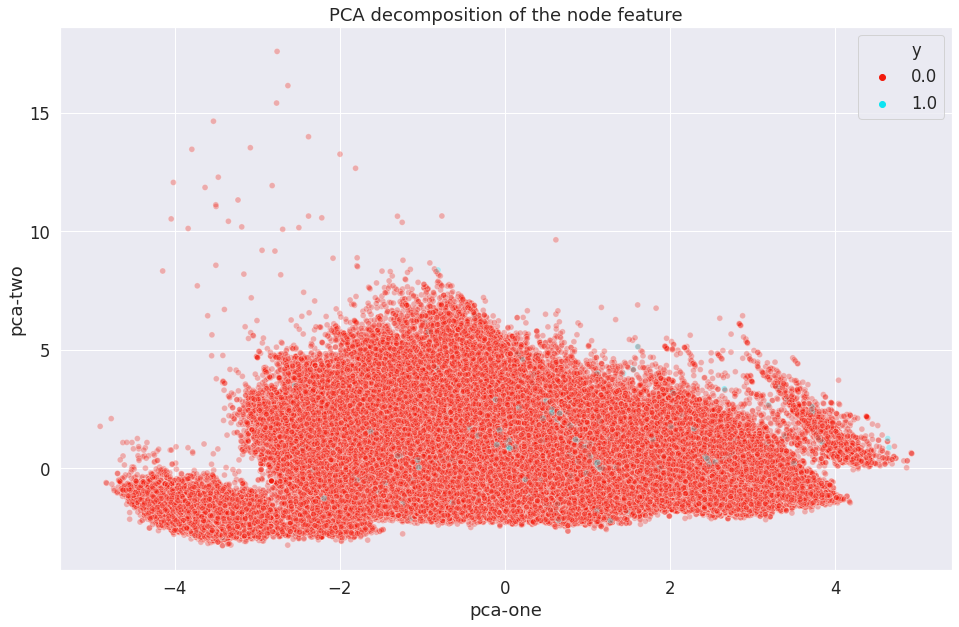

In [125]:
plt.figure(figsize=(16,10))
sns.set(font_scale=1.5)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.hls_palette(2, l=.5, s=.9),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.title("PCA decomposition of the node feature")
plt.savefig("/content/drive/My Drive/PhD/Homework/DL_project/pca.png", format='png')

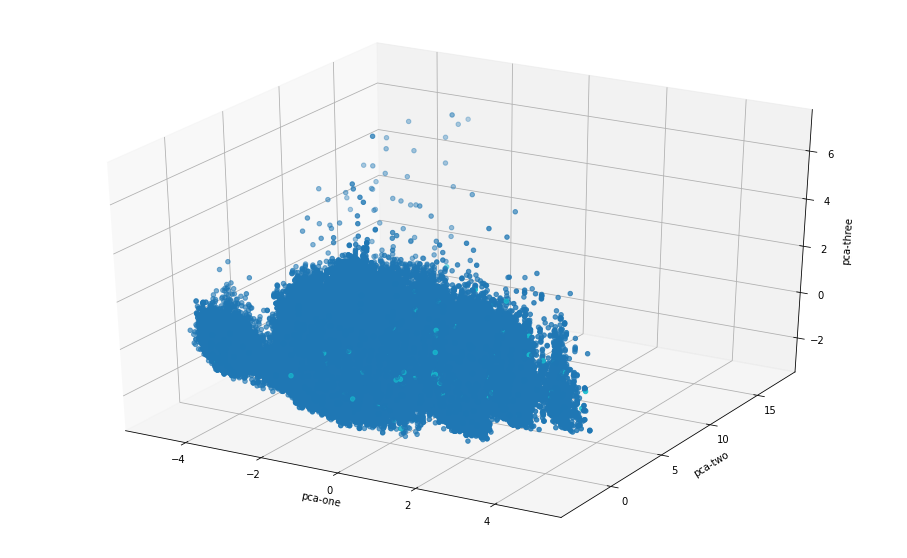

In [86]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [87]:
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.23699289 0.16956329 0.0679459 ]


In [118]:

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done!')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.058s...
[t-SNE] Computed neighbors for 10000 samples in 6.149s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.886143
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.289307
[t-SNE] KL divergence after 5000 iterations: 1.197429
t-SNE done!


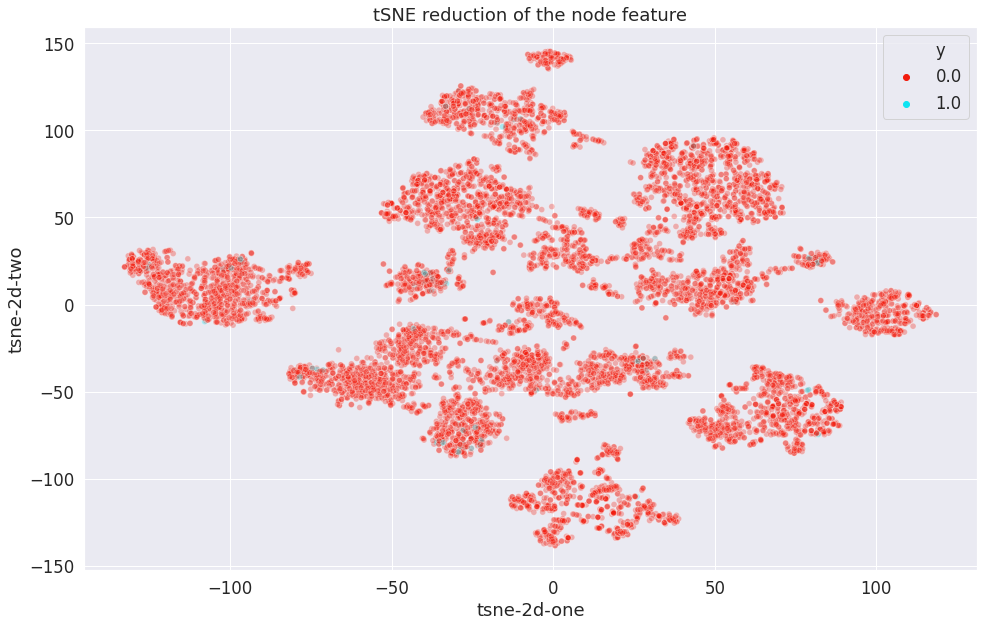

In [123]:
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.set(font_scale=1.5)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.hls_palette(2, l=.5, s=.9),
    data=df_subset,
    legend="full",
    alpha=0.3
)
plt.title("tSNE reduction of the node feature")
plt.savefig("/content/drive/My Drive/PhD/Homework/DL_project/tsne.png", format='png')

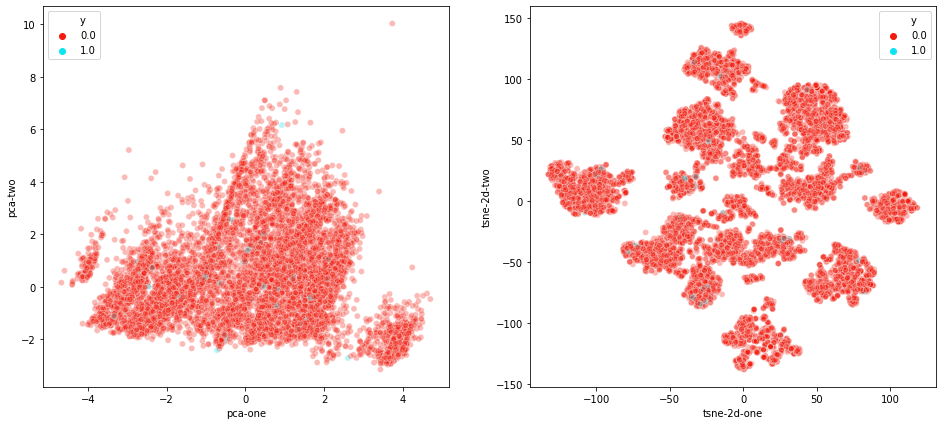

In [120]:
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.hls_palette(2, l=.5, s=.9),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.hls_palette(2, l=.5, s=.9),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

In [ ]:
#json_files = glob.glob("/content/drive/My Drive/PhD/Homework/DL_project/data/json/*.json")

json_files = glob.glob("/content/json/*.json")
#print(len(json_files))
with open(json_files[2], 'r') as json_file:
  print(json_files[2])
  data = json.load(json_file) 
  graph = json.loads(data[0])
  labels = json.loads(data[1])


IndexError: ignored

In [ ]:
'''with open(json_files[0],'r') as jfile:
  graph = nx.node_link_graph(graph)
  g = dgl.DGLGraph()
  g.from_networkx(graph,node_attrs=['features','x','y','chain_id'],edge_attrs=['features'])'''

"with open(json_files[0],'r') as jfile:\n  graph = nx.node_link_graph(graph)\n  g = dgl.DGLGraph()\n  g.from_networkx(graph,node_attrs=['features','x','y','chain_id'],edge_attrs=['features'])"

In [ ]:
from dgl.data.utils import load_graphs
from glob import glob

graph_l=glob('Graphs/*')
Graphs=[]
for i in graph_l:
  glist, label_dict = load_graphs(i)
  Graphs.append(glist)

In [ ]:
a[0].ndata

{'h': tensor([[1.6000, 0.1300, 2.9500,  ..., 6.5200, 0.2100, 0.2200],
        [1.2800, 0.0500, 1.0000,  ..., 6.1100, 0.4200, 0.2300],
        [1.8900, 0.2200, 4.7700,  ..., 9.9900, 0.3200, 0.2700],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), 'asa': tensor([[16328.],
        [ 7208.],
        [22345.],
        [20088.],
        [ 5216.],
        [27776.],
        [ 4563.],
        [  788.],
        [ 2982.],
        [22320.],
        [  142.],
        [ 6438.],
        [10205.],
        [ 1846.],
        [ 3760.],
        [24600.],
        [39432.],
        [ 1014.],
        [ 6594.],
        [11205.],
        [ 4531.],
        [    0.],
        [13973.],
        [26855.],
        [ 1413.],
        [ 6591.],
        [16400.],
        [ 6355.],
        [ 7540.],
        [ 5330.],
        [14058.],
        [11247.],
        [ 45

In [ ]:
#acat=th.cat((a[0].ndata),dim=1)
len(a[0].ndata)

6

In [ ]:
src = list()
dst = list()

# Get source and destination of edges
for i in  graph["links"]:
  src.append(i['source'])
  dst.append(i['target'])
residues = list(sorted(set(src + dst)))
# Creat map of AA number to nodes with starting idx 0
node_idx  = 0
previous_aa = residues[0]
residue_map = dict()
for i in range(0, len(residues)):
  if residues[i] != previous_aa:
    node_idx += 1
  residue_map[residues[i]] = node_idx
  
  previous_aa = residues[i]
# DGL graph has to start at 0 renumber AA
src = np.array([residue_map[i] for i in src])
dst = np.array([residue_map[i] for i in dst])
print(residue_map)
print(len(residues))
print(src)
print(dst)
#sorted(node_map.keys())

{'A100ASN': 0, 'A101PRO': 1, 'A102THR': 2, 'A103TYR': 3, 'A104LYS': 4, 'A105GLU': 5, 'A106VAL': 6, 'A107CYS': 7, 'A108SER': 8, 'A109GLY': 9, 'A110LYS': 10, 'A111THR': 11, 'A112GLY': 12, 'A113HIS': 13, 'A114ALA': 14, 'A115GLU': 15, 'A116VAL': 16, 'A117VAL': 17, 'A118ARG': 18, 'A119VAL': 19, 'A120VAL': 20, 'A121PHE': 21, 'A122GLN': 22, 'A123PRO': 23, 'A124GLU': 24, 'A125HIS': 25, 'A126ILE': 26, 'A127SER': 27, 'A128PHE': 28, 'A129GLU': 29, 'A130GLU': 30, 'A131LEU': 31, 'A132LEU': 32, 'A133LYS': 33, 'A134VAL': 34, 'A135PHE': 35, 'A136TRP': 36, 'A137GLU': 37, 'A138ASN': 38, 'A139HIS': 39, 'A140ASP': 40, 'A141PRO': 41, 'A142THR': 42, 'A143GLN': 43, 'A144GLY': 44, 'A145MET': 45, 'A146ARG': 46, 'A147GLN': 47, 'A148GLY': 48, 'A149ASN': 49, 'A150ASP': 50, 'A151HIS': 51, 'A152GLY': 52, 'A153SER': 53, 'A154GLN': 54, 'A155TYR': 55, 'A156ARG': 56, 'A157SER': 57, 'A158ALA': 58, 'A159ILE': 59, 'A160TYR': 60, 'A161PRO': 61, 'A162THR': 62, 'A163SER': 63, 'A164ALA': 64, 'A165GLU': 65, 'A166HIS': 66, 'A16

In [ ]:
src = list()
dst = list()

# Get source and destination of edges
for i in  graph["links"]:
  src.append(i['source'])
  dst.append(i['target'])
residues = list(sorted(set(src + dst)))
# Creat map of AA number to nodes with starting idx 0
node_idx  = 0
previous_aa = residues[0]
residue_map = dict()
for i in range(0, len(residues)):
  if residues[i] != previous_aa:
    node_idx += 1
  residue_map[residues[i]] = node_idx
  
  previous_aa = residues[i]

# DGL graph has to start at 0 renumber AA
src = np.array([residue_map[i] for i in src])
dst = np.array([residue_map[i] for i in dst])

#Make Graph bidirectional
u = np.concatenate([src, dst])
v = np.concatenate([dst, src])

# Map features to node id
node_map = dict()
for i in graph["nodes"]:
  if i['id'] in residue_map.keys():
    tmp = dict()
    tmp['label'] = labels[i['id']] 
    #print(i["resi_num"], i["resi_num"])
    node_map[i["id"]] = {**i, **tmp}

# Create DGL object
G = dgl.DGLGraph((u,v))
pos = nx.kamada_kawai_layout(G.to_networkx())
nx.draw(G.to_networkx(), pos, with_labels=True)

label_tensor = th.tensor([node_map[i]['label'] for i in node_map.keys()])
print(label_tensor).shape
# Add features to each node
G.ndata['features'] = th.zeros(len(G), len(node_map[list(node_map.keys())[0]]['features'][0]))
G.ndata['label'] = th.zeros(len(G), len(label_tensor))
#print(G.ndata['features'])
for i in node_map.keys():
  #print(th.tensor(node_map[i]['features'][0]))
  G.ndata['features'][residue_map[i]] = th.tensor(node_map[i]['features'][0])
  G.ndata['label'][residue_map[i]] = label_tensor


NameError: ignored

In [ ]:
G

DGLGraph(num_nodes=401, num_edges=1508,
         ndata_schemes={'features': Scheme(shape=(36,), dtype=torch.float32), 'label': Scheme(shape=(401,), dtype=torch.float32)}
         edata_schemes={})

In [ ]:
G.nodes[residue_map['C200ASP']]

NodeSpace(data={'features': tensor([[ 0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.7389,
         -0.1438,  5.0000, 34.2144,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  1.0000]]), 'label': tensor([[0., 0., 0.,  ..., 0., 0., 0.]])})

In [ ]:
len(G.ndata['features'][1])

36

In [ ]:
residue_map['B138SER']

499

In [ ]:
node_map['D200ASP']

KeyError: ignored

In [ ]:
#Lucas end of experiment

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, path):
      json_files = glob.glob(os.path.join(path, "*.json"))
      self.graphs=[]
      for fname in tqdm(json_files):
        with open(fname, 'r') as json_file:
          data = json.load(json_file) 
          graph = json.loads(data[0])
          labels = json.loads(data[1])
        
        src = list()
        dst = list()

  # Get source and destination of edges
        for i in  graph["links"]:
          src.append(i['source'])
          dst.append(i['target'])
        residues = list(sorted(set(src + dst)))
  # Creat map of AA number to nodes with starting idx 0
        node_idx  = 0
        previous_aa = residues[0]
        residue_map = dict()
        for i in range(0, len(residues)):
          if residues[i] != previous_aa:
            node_idx += 1
          residue_map[residues[i]] = node_idx
          
          previous_aa = residues[i]
  # DGL graph has to start at 0 renumber AA
        src = np.array([residue_map[i] for i in src])
        dst = np.array([residue_map[i] for i in dst])

  #Make Graph bidirectional
        u = np.concatenate([src, dst])
        v = np.concatenate([dst, src])

  # Map features to node id
        node_map = dict()
        for i in graph["nodes"]:
          if i['id'] in residue_map.keys():
            tmp = dict()
            tmp['label'] = labels[i['id']] 
            node_map[i["id"]] = {**i, **tmp}
  # Create DGL object
        G = dgl.DGLGraph((u,v))
      
        label_tensor = th.tensor([node_map[i]['label'] for i in node_map.keys()])
        #print(label_tensor.shape)

  # Add features to each node
        G.ndata['features'] = th.zeros(len(G), len(node_map[list(node_map.keys())[0]]['features'][0]))
        G.ndata['label'] = th.zeros(len(G), len(label_tensor))
      

        for i in node_map.keys():
          
          G.ndata['features'][residue_map[i]] = th.tensor(node_map[i]['features'][0])
        G.ndata['label'] = label_tensor      

      
        self.graphs.append(G)
        
          
    def __len__(self):
       
        return len(self.graphs)


    def __getitem__(self, idx):
        
    
        return self.graphs[idx], self.graphs[idx].ndata['label']

In [ ]:

train_ds=CustomDataset('/content/json/train_ds')
valid_ds=CustomDataset('/content/json/valid_ds')
#train_ds = CustomDataset("/content/drive/My Drive/PhD/Homework/DL_project/data/json/") 

In [ ]:
train_ds[2]

(DGLGraph(num_nodes=401, num_edges=1508,
          ndata_schemes={'features': Scheme(shape=(36,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32)}
          edata_schemes={}),
 tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0

In [ ]:
def collate(samples):
    
    # The input `samples` is a list, a batch of whatever comes out of your dataset object
    
    graphs = [x[0] for x in samples]
    labels = [x[1] for x in samples]
    
    batched_graph = dgl.batch(graphs,node_attrs=['features'])
    targets = th.cat(labels)
    
    return batched_graph, targets.unsqueeze(1).float()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
class EdgeNetwork(nn.Module):
    def __init__(self):
        super(EdgeNetwork, self).__init__()
        
        self.edgelayer1=nn.Linear(128*2+36*2,128)
        self.edgelayer2=nn.Linear(128,256)
        
    def forward(self, x):
      #print(x.dst['node_features'].shape,x.src['node_hidden_state'].shape)
      x=th.cat((x.dst['features'], x.dst['node_hidden_state'],x.src['features'], x.src['node_hidden_state']),dim=1)
      #print(x.shape)
      output=F.relu(self.edgelayer1(x))  
        #your input x is an object with the following properties:
        #x.dst['node_features'], x.dst['node_hidden_state']
        #x.src['node_features'], x.src['node_hidden_state']
        #x.data['distance']
        
        #put them together with torch.cat
        
        #use a neural network to create an edge hidden represetation - 
        
        #you return a dictionary with what you want to "send" to the reciving node
      output=self.edgelayer2(output) 
      return {'edge hidden represetation': output }

    
class NodeNetwork(nn.Module):
    def __init__(self):
        super(NodeNetwork, self).__init__()
        self.nodelayer1=nn.Linear(256+128+36,256)
        self.nodelayer2=nn.Linear(256,128)
        
    def forward(self, x):
      x_sum=th.mean(x.mailbox['edge hidden represetation'],dim=1)
      #print(x_sum.shape, x.data['node_hidden_state'].shape, x.data['node_features'].shape)
      x=th.cat((x_sum,x.data['node_hidden_state'], x.data['features']),dim=1)
      out=F.relu(self.nodelayer1(x))        
        #this time your input x has:
        # x.mailbox['edge hidden represetation'] -> this is what you send with the edge update function above - 
        # it will have the size of the node neighborhood - 
        # (Batch size, number of nodes in neighborhood, edge hidden rep size), so you need to sum/mean over dim=1 
        # x.data['node_hidden_state'] and x.data['node_features'] (this is the existing state of your node)
        # you need to torch.cat the message sum, node hidden state, and node features 
        #- and then apply some fully connected neural network
        
        # return a new hidden state for the node
      out=self.nodelayer2(out)
      return {'node_hidden_state': out }

class NodeNetworkClassifeir(nn.Module):
    def __init__(self):
        super(NodeNetworkClassifeir, self).__init__()
        
        self.nodelayerC1=nn.Linear(36+128,64)
        self.nodelayerC2=nn.Linear(64,1)
        
    def forward(self, x):
      #x_sum=torch.mean(x.mailbox['edge hidden represetation'],dim=1)
      x=th.cat((x.data['features'], x.data['node_hidden_state']),dim=1)
      output=F.relu(self.nodelayerC1(x))  
        
      output=self.nodelayerC2(output) 
      return {'node_class_prediction': output }


class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        
        # you need to create a network that 
        # will initialize your node hidden state based only on the node features -
        #self.node_feat_size=g.ndata['features'].shape[1]
        self.node_hid_size=128
        self.node_init = nn.Sequential(
                nn.Linear(36,64),
                nn.ReLU(),
            nn.Linear(64,self.node_hid_size))
        
        self.edge_network = EdgeNetwork()
        self.node_network = NodeNetwork()
        
        #this edge classifier is also an edge update function - 
        #but it needs to return something of size 1 (the edge class prediction)
        #so either create a different model for this, or make the EdgeNetwork configurable
        self.node_classifier = NodeNetworkClassifeir()
        
    def forward(self, g):
        
        g.ndata['node_hidden_state'] = self.node_init(g.ndata['features'])
        #print(g.ndata['node_hidden_state'].shape)
        for i in range(8):
            
            g.update_all(self.edge_network,self.node_network)
            
        
        #we want to classify the nodes - so finally apply your edge classifier -
        g.apply_nodes(self.node_classifier)
        
        #and extract its output 
        out = g.ndata['node_class_prediction']

        
        return out 

In [ ]:
net=Classifier()

In [ ]:
perd=net(valid_ds[0][0])


In [ ]:
#valid_ds[0][0]
perd

tensor([[-0.0312],
        [-0.0362],
        [-0.0551],
        [-0.0368],
        [-0.0344],
        [-0.0626],
        [-0.1182],
        [-0.0625],
        [-0.0795],
        [-0.0577],
        [-0.0968],
        [-0.0650],
        [-0.1621],
        [-0.1097],
        [-0.1544],
        [-0.1363],
        [-0.1038],
        [-0.0478],
        [-0.1640],
        [-0.0821],
        [ 0.0028],
        [-0.1211],
        [-0.0184],
        [-0.1226],
        [-0.0764],
        [-0.0452],
        [-0.1050],
        [-0.0926],
        [-0.0591],
        [ 0.0049],
        [-0.0599],
        [-0.0475],
        [-0.0964],
        [-0.1210],
        [-0.0646],
        [-0.0401],
        [-0.0211],
        [-0.0223],
        [-0.1213],
        [-0.1269],
        [-0.1145],
        [-0.1120],
        [-0.0797],
        [-0.0854],
        [-0.0636],
        [-0.1368],
        [-0.0140],
        [-0.0148],
        [-0.0684],
        [-0.0558],
        [-0.0059],
        [-0.1014],
        [-0.

In [ ]:
# the basic "graph attention layer" and the way to pass the information from node to node

class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.fc.weight, gain=gain)
        nn.init.xavier_normal_(self.attn_fc.weight, gain=gain)

    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e': F.leaky_relu(a)}

    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z': edges.src['z'], 'e': edges.data['e']}

    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h': h}

    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [ ]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge

    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [ ]:
#the real model
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        # multiple head outputs are concatenated together. Also, only
        # one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)

    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [ ]:
# loading data here 
data_loader = DataLoader(train_ds, batch_size=30, shuffle=True,
                         collate_fn=collate)
data_loader_test=DataLoader(valid_ds, batch_size=30,shuffle=True,collate_fn=collate)

In [ ]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
if th.cuda.is_available():
    net.cuda()
use_cuda = th.cuda.is_available()
device = th.device('cuda:0' if use_cuda else 'cpu')

RuntimeError: ignored

In [ ]:
##training for simple net
n_epoch = 20

epoch_losses, epoch_val_losses = [], []
for epoch in range(1, n_epoch+1):
    epoch_loss = 0
    iter_batch = 0
    net.train()
    for x, y in data_loader:
      x = x.to(th.device('cuda'))
      y = y.cuda()

      prediction = net(x)
        
      loss = loss_func(prediction, y )
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      epoch_loss += loss.detach().item()
      iter_batch += 1
    epoch_loss /= (iter_batch + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)
    
    
    epoch_val_loss = 0
    iter_batch_val = 0
    net.eval()
    for bg, label in data_loader_test:
      bg=bg.to(th.device('cuda'))
      label=label.cuda()   
      prediction = net(bg)
      loss = loss_func(prediction, label )
      epoch_val_loss += loss.detach().item()
      iter_batch_val += 1
    epoch_val_loss /= (iter_batch_val + 1)
    #print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_val_losses.append(epoch_val_loss)
    print('Epoch {}, loss {:.4f}, val_loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

Epoch 1, loss 0.1265, val_loss 0.0553
Epoch 2, loss 0.0532, val_loss 0.0506
Epoch 3, loss 0.0459, val_loss 0.0413
Epoch 4, loss 0.0385, val_loss 0.0392
Epoch 5, loss 0.0364, val_loss 0.0356
Epoch 6, loss 0.0346, val_loss 0.0344
Epoch 7, loss 0.0338, val_loss 0.0334
Epoch 8, loss 0.0340, val_loss 0.0351
Epoch 9, loss 0.0329, val_loss 0.0328
Epoch 10, loss 0.0327, val_loss 0.0344
Epoch 11, loss 0.0321, val_loss 0.0319
Epoch 12, loss 0.0312, val_loss 0.0312
Epoch 13, loss 0.0319, val_loss 0.0311
Epoch 14, loss 0.0315, val_loss 0.0322
Epoch 15, loss 0.0325, val_loss 0.0310
Epoch 16, loss 0.0307, val_loss 0.0304
Epoch 17, loss 0.0318, val_loss 0.0313
Epoch 18, loss 0.0310, val_loss 0.0303
Epoch 19, loss 0.0312, val_loss 0.0310
Epoch 20, loss 0.0304, val_loss 0.0302


RuntimeError: ignored

In [ ]:
##training.

import time
import numpy as np

g, features, labels, mask = load_cora_data()

# create the model, 2 heads, each head has hidden size 8
net = GAT(g,
          in_dim=features.size()[1],
          hidden_dim=8,
          out_dim=7,
          num_heads=2)

# create optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# main loop
dur = []
for epoch in range(30):
    if epoch >= 3:
        t0 = time.time()

    logits = net(features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[mask], labels[mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch >= 3:
        dur.append(time.time() - t0)

    print("Epoch {:05d} | Loss {:.4f} | Time(s) {:.4f}".format(
        epoch, loss.item(), np.mean(dur)))

In [ ]:
valid_ds[0][0]

DGLGraph(num_nodes=264, num_edges=1058,
         ndata_schemes={'features': Scheme(shape=(36,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.float32)}
         edata_schemes={})

In [ ]:
net.eval()
pred=net(valid_ds[0][0])

tensor([[-0.0312],
        [-0.0362],
        [-0.0551],
        [-0.0368],
        [-0.0344],
        [-0.0626],
        [-0.1182],
        [-0.0625],
        [-0.0795],
        [-0.0577],
        [-0.0968],
        [-0.0650],
        [-0.1621],
        [-0.1097],
        [-0.1544],
        [-0.1363],
        [-0.1038],
        [-0.0478],
        [-0.1640],
        [-0.0821],
        [ 0.0028],
        [-0.1211],
        [-0.0184],
        [-0.1226],
        [-0.0764],
        [-0.0452],
        [-0.1050],
        [-0.0926],
        [-0.0591],
        [ 0.0049],
        [-0.0599],
        [-0.0475],
        [-0.0964],
        [-0.1210],
        [-0.0646],
        [-0.0401],
        [-0.0211],
        [-0.0223],
        [-0.1213],
        [-0.1269],
        [-0.1145],
        [-0.1120],
        [-0.0797],
        [-0.0854],
        [-0.0636],
        [-0.1368],
        [-0.0140],
        [-0.0148],
        [-0.0684],
        [-0.0558],
        [-0.0059],
        [-0.1014],
        [-0.

In [ ]:
def F1_score(net, data_loder_test, loss_func):
  net.eval()
  
  for v in valid_ds:
    gr=v[0]
    label=v[1]
    relev_ones=label.count(1)
    pred=net(v[0])
    all_positive=pred.count(1)
    for i,l in enumerate(label)):
      true_pos=0
      rounded_pred=round(pred[0][i])
      if rounded_pred ==1 and l==1:
        true_pos+=1
    precision=true_pos/all_positive
    recall=true_pos/relev_ones
    F1_scores.append(2*(precision*recall)/(precision+recall)) 
     
